In [20]:
import os
import time
import uuid
import cv2

## Collect images using OpenCV

In [21]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [54]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [55]:
!labelme

## Review dataset and build image loading function

In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load images into TF data pipeline

In [23]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [58]:
images.as_numpy_iterator().next()

b'data\\images\\e6589695-8ebc-11ed-add1-089798be260c.jpg'

In [24]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [25]:
images = images.map(load_img)

NameError: name 'images' is not defined

In [61]:
images.as_numpy_iterator().next()

array([[[211, 213, 208],
        [213, 215, 210],
        [214, 216, 211],
        ...,
        [211, 200, 208],
        [208, 195, 204],
        [208, 192, 202]],

       [[212, 214, 209],
        [213, 215, 210],
        [214, 216, 211],
        ...,
        [206, 196, 204],
        [208, 195, 204],
        [210, 197, 206]],

       [[213, 214, 209],
        [215, 216, 211],
        [216, 216, 214],
        ...,
        [207, 198, 203],
        [205, 194, 200],
        [207, 196, 202]],

       ...,

       [[185, 190, 186],
        [186, 191, 187],
        [186, 188, 183],
        ...,
        [ 16,  16,  16],
        [ 22,  22,  22],
        [ 23,  23,  23]],

       [[193, 195, 192],
        [189, 191, 188],
        [188, 190, 187],
        ...,
        [ 16,  16,  18],
        [ 21,  22,  24],
        [ 21,  22,  24]],

       [[193, 195, 192],
        [188, 190, 187],
        [189, 191, 188],
        ...,
        [ 18,  18,  20],
        [ 18,  19,  21],
        [ 14,  15,  17]]

In [62]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [63]:
image_generator = images.batch(4).as_numpy_iterator()

In [64]:
plot_images = image_generator.next()

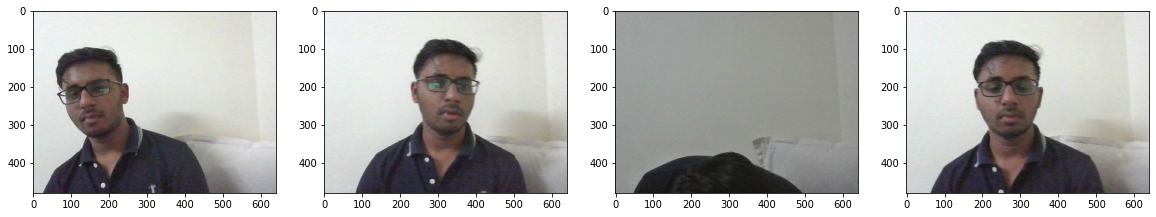

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)


## Partition unaugmented data

Divide images manually into train, test, val

Move matching labels into respective folders

In [26]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## Apply image augmentation

In [76]:
import albumentations as alb

In [77]:
img = cv2.imread(os.path.join('data','train','images','cf5cd54a-8ebc-11ed-a23b-089798be260c.jpg'))
img.shape

(480, 640, 3)

In [78]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
],bbox_params=alb.BboxParams(
    format='albumentations',
    label_fields=['class_labels']
))

In [79]:
img = cv2.imread(os.path.join('data','train','images','cf5cd54a-8ebc-11ed-a23b-089798be260c.jpg'))
with open(os.path.join('data','train','labels','cf5cd54a-8ebc-11ed-a23b-089798be260c.json'),'r') as f:
    label = json.load(f)

In [80]:
label['shapes'][0]['points']

[[194.58100558659214, 65.69832402234638],
 [414.1340782122905, 339.44134078212295]]

## Apply augmentation

In [82]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f"{image.split('.')[0]}.json")
        
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f"{image.split('.')[0]}.{x}.jpg"), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition,'labels',f"{image.split('0')[0]}.{x}.json"),'w') as f:
                    json.dump(annotation,f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.3468051675977653, 0.21717877094972068, 0.0011347765363128094, 0.9317970204841715, 'face'].
x_max is less than or equal to x_min for bbox [0.2311698717948718, 0.28205128205128205, -4.4408920985006264e-17, 0.8651551772453414, 'face'].


In [28]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [29]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [30]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [31]:
train_images.as_numpy_iterator().next()

array([[[0.96617645, 0.9259804 , 0.94987744],
        [0.9581495 , 0.9306985 , 0.9581495 ],
        [0.9607843 , 0.9411765 , 0.95686275],
        ...,
        [0.8833333 , 0.8833333 , 0.8519608 ],
        [0.8745098 , 0.8784314 , 0.84705883],
        [0.89601713, 0.8793505 , 0.8543505 ]],

       [[0.9653799 , 0.9472426 , 0.9624387 ],
        [0.9676471 , 0.9495098 , 0.9647059 ],
        [0.9460784 , 0.9382353 , 0.95      ],
        ...,
        [0.89375   , 0.88284314, 0.8632353 ],
        [0.8792892 , 0.87800246, 0.84705883],
        [0.87579656, 0.8630515 , 0.8409926 ]],

       [[0.94528186, 0.9374387 , 0.94920343],
        [0.9538603 , 0.94601715, 0.95778185],
        [0.95980394, 0.9519608 , 0.9637255 ],
        ...,
        [0.8858456 , 0.86807597, 0.8514706 ],
        [0.8863358 , 0.8745711 , 0.8471201 ],
        [0.89981616, 0.87530637, 0.85177696]],

       ...,

       [[0.8504902 , 0.82303923, 0.8504902 ],
        [0.8426471 , 0.8151961 , 0.84656864],
        [0.843076  , 0

## Prepare Labels

In [32]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [33]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [34]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.368  , 0.07935, 0.856  , 0.6875 ], dtype=float16))

## Combine Label and Image Samples

In [37]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2580, 2580, 420, 420, 480, 480)

In [38]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [39]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [40]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [41]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.      , 0.001974, 0.1588  , 0.69    ],
        [0.4753  , 0.11194 , 1.      , 0.727   ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.1335  , 0.2485  , 0.628   , 0.89    ],
        [0.3123  , 0.3887  , 0.693   , 0.862   ],
        [0.4631  , 0.3044  , 0.9023  , 0.8843  ],
        [0.      , 0.2123  , 0.4487  , 0.888   ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

In [42]:
data_samples = train.as_numpy_iterator()

In [43]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


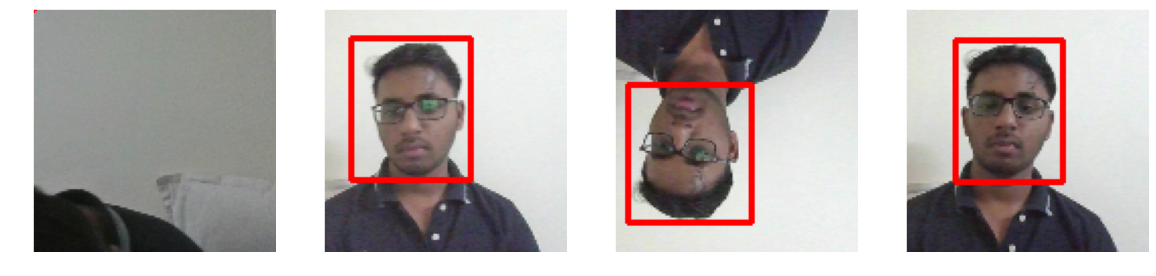

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Build Deep Learning using the Functional API

In [45]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16

In [46]:
vgg = VGG16(include_top=False)

In [47]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [48]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [49]:
facetracker = build_model()

In [50]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [51]:
X, y = train.as_numpy_iterator().next()

In [52]:
X.shape

(8, 120, 120, 3)

In [53]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 4s 4s/step


In [54]:
classes, coords

(array([[0.39338255],
        [0.48604995],
        [0.39958072],
        [0.46621883],
        [0.5220353 ],
        [0.45783478],
        [0.4570534 ],
        [0.48768878]], dtype=float32),
 array([[0.6289006 , 0.3276999 , 0.6227689 , 0.292891  ],
        [0.56316245, 0.45993984, 0.52997684, 0.43081188],
        [0.6487352 , 0.48839578, 0.5497179 , 0.39126307],
        [0.6564239 , 0.31623024, 0.6378907 , 0.3174742 ],
        [0.58557165, 0.38141105, 0.5852902 , 0.36389703],
        [0.57165223, 0.43508258, 0.5346744 , 0.4142367 ],
        [0.6143027 , 0.50087005, 0.55126303, 0.4203517 ],
        [0.56427103, 0.44452748, 0.5418204 , 0.4406923 ]], dtype=float32))

## Define Losses and Optimizers

In [55]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [56]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [57]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [58]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [59]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.5695295>

In [60]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.70925105>

In [61]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.5695295>

## Train Neural Network

In [62]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [63]:
model = FaceTracker(facetracker)

In [64]:
model.compile(opt, classloss, regressloss)

In [125]:
logdir='logs'

In [126]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [127]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
323/323 [==============================] - 39s 100ms/step - total_loss: 0.2980 - class_loss: 0.0655 - regress_loss: 0.2652 - val_total_loss: 0.0287 - val_class_loss: 0.0025 - val_regress_loss: 0.0274
Epoch 2/10
323/323 [==============================] - 35s 99ms/step - total_loss: 0.0632 - class_loss: 0.0131 - regress_loss: 0.0567 - val_total_loss: 0.0267 - val_class_loss: 7.4750e-04 - val_regress_loss: 0.0263
Epoch 3/10
323/323 [==============================] - 35s 99ms/step - total_loss: 0.0503 - class_loss: 0.0145 - regress_loss: 0.0430 - val_total_loss: 0.0244 - val_class_loss: 0.0017 - val_regress_loss: 0.0235
Epoch 4/10
323/323 [==============================] - 34s 96ms/step - total_loss: 0.0419 - class_loss: 0.0089 - regress_loss: 0.0375 - val_total_loss: 0.0221 - val_class_loss: 3.5611e-04 - val_regress_loss: 0.0219
Epoch 5/10
323/323 [==============================] - 34s 96ms/step - total_loss: 0.0190 - class_loss: 0.0040 - regress_loss: 0.0170 - val_total_loss: 

In [128]:
hist.history

{'total_loss': [0.05001644790172577,
  0.0035490896552801132,
  0.013344964012503624,
  0.0038008177652955055,
  0.0005121786962263286,
  0.0029080775566399097,
  0.0026871017180383205,
  0.0007331463857553899,
  0.0035735236015170813,
  0.0025738084223121405],
 'class_loss': [0.0003617164329625666,
  0.000305177120026201,
  0.000551708391867578,
  0.00031434601987712085,
  6.526767720060889e-06,
  1.773244321157108e-06,
  0.00012100409367121756,
  5.722111382056028e-06,
  4.378144512884319e-05,
  6.220152135938406e-05],
 'regress_loss': [0.04983558878302574,
  0.0033965010661631823,
  0.013069109991192818,
  0.00364364474080503,
  0.0005089152837172151,
  0.002907190937548876,
  0.002626599743962288,
  0.0007302853045985103,
  0.0035516328644007444,
  0.0025427076034247875],
 'val_total_loss': [0.02867416851222515,
  0.026657573878765106,
  0.02435421012341976,
  0.022112293168902397,
  0.014342454262077808,
  0.013951361179351807,
  0.024072907865047455,
  0.013105013407766819,
  0.0

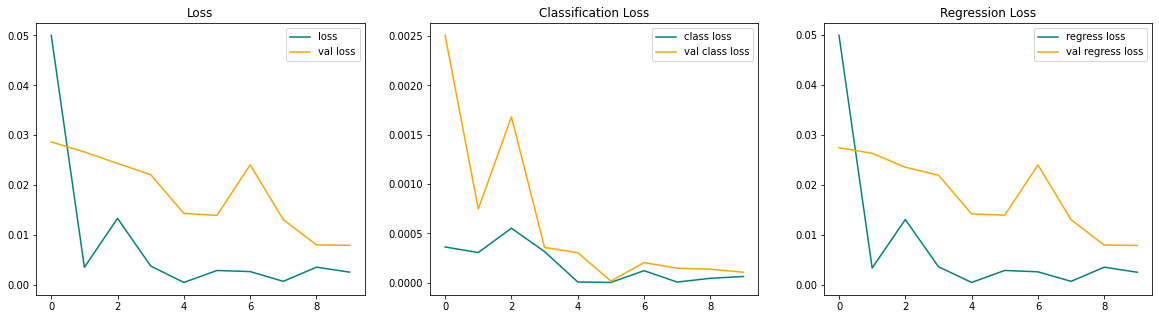

In [129]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

In [130]:
test_data = test.as_numpy_iterator()

In [131]:
test_sample = test_data.next()

In [132]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


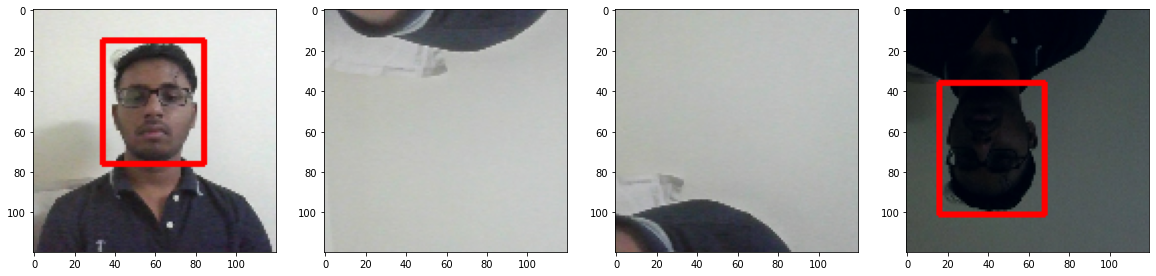

In [133]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [1]:
from keras.models import load_model
import cv2
import tensorflow as tf
import numpy as np


In [2]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

In [2]:
facetracker = load_model('facetracker.h5')

## Real Time Detection

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
